In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np

import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [19]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        max_len=5000,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=max_len
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    print("start training loop")
    for batch in tqdm(dataloader):
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [22]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [23]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list


In [24]:
def predict(model, input_sequence, max_length=MAX_LEN, SOS_token=SOS, EOS_token=EOS):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()

## Song Data

In [25]:
# 119 tokens
# <PAD> 120
# <SOS> 121
# <EOS> 122
PAD = 120
SOS = 121
EOS = 122

MAX_LEN = 1024

In [26]:
with open('data.json', 'r') as fp:
    data = json.load(fp)

token_list = []
for song in data:
    token_list.append(data[song])

len(token_list)

803

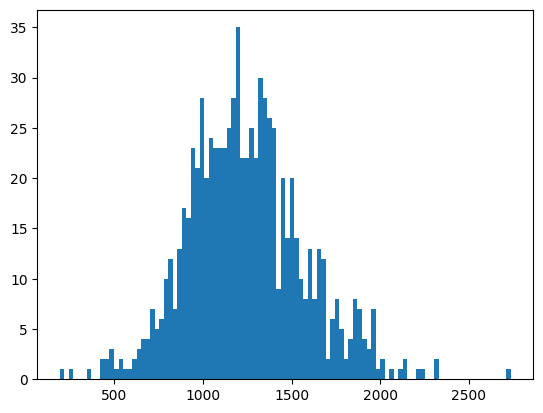

In [27]:
lengths = [len(song) for song in token_list]
plt.hist(lengths, bins=100)
plt.show()

In [28]:
def batchify_data_max_token_length(data, batch_size=16, padding=True, padding_token=PAD, start_token=SOS, end_token=EOS, max_token_lengths=1024):
    batches = []
    for idx in range(0, len(data), batch_size): # HIER GEHEN DIE LETZTEN 3 SONGS VERLOREN
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            if padding:
                for seq_idx in range(batch_size):
                    # when song length smaller add <PAD> else cut tokens
                    if len(data[idx + seq_idx]) < max_token_lengths-2:
                        remaining_length = max_token_lengths - 2 - len(data[idx + seq_idx])
                        data[idx + seq_idx] = [start_token] + data[idx + seq_idx] + [end_token] + [padding_token] * remaining_length
                    else:
                        data[idx + seq_idx] = [start_token] + data[idx + seq_idx][:max_token_lengths-2] + [end_token]
            # double token seq as in and output
            data[idx : idx + batch_size] = [[token_seq, token_seq] for token_seq in data[idx : idx + batch_size]]
            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches

In [29]:
batches_train = batchify_data_max_token_length(token_list[:720], max_token_lengths=1024)
batches_test = batchify_data_max_token_length(token_list[720:], max_token_lengths=1024)

44 batches of size 16
5 batches of size 16


In [30]:
print(type(batches_train))
print(len(batches_train))
print(type(batches_train[0]))
print(batches_train[2].shape)

<class 'list'>
44
<class 'numpy.ndarray'>
(16, 2, 1024)


In [31]:
[len(song) for song in batches_train[3][2]]

[1024, 1024]

In [32]:
model = Transformer(
    num_tokens=123, dim_model=8, num_heads=8, num_encoder_layers=12, num_decoder_layers=12, dropout_p=0,
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [33]:
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, batches_train, batches_test, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
start training loop


100%|██████████| 44/44 [1:35:13<00:00, 129.86s/it]


Training loss: 4.7444
Validation loss: 4.6385

------------------------- Epoch 2 -------------------------
start training loop


100%|██████████| 44/44 [53:59<00:00, 73.62s/it]


Training loss: 4.5942
Validation loss: 4.5421

------------------------- Epoch 3 -------------------------
start training loop


100%|██████████| 44/44 [52:58<00:00, 72.24s/it]


Training loss: 4.4964
Validation loss: 4.4533

------------------------- Epoch 4 -------------------------
start training loop


100%|██████████| 44/44 [53:17<00:00, 72.67s/it]


Training loss: 4.4039
Validation loss: 4.3687

------------------------- Epoch 5 -------------------------
start training loop


100%|██████████| 44/44 [51:55<00:00, 70.82s/it]


Training loss: 4.3156
Validation loss: 4.2883

------------------------- Epoch 6 -------------------------
start training loop


100%|██████████| 44/44 [51:46<00:00, 70.60s/it]


Training loss: 4.2328
Validation loss: 4.2127

------------------------- Epoch 7 -------------------------
start training loop


100%|██████████| 44/44 [51:43<00:00, 70.53s/it]


Training loss: 4.1568
Validation loss: 4.1435

------------------------- Epoch 8 -------------------------
start training loop


100%|██████████| 44/44 [51:44<00:00, 70.56s/it]


Training loss: 4.0889
Validation loss: 4.0824

------------------------- Epoch 9 -------------------------
start training loop


100%|██████████| 44/44 [51:06<00:00, 69.69s/it]


Training loss: 4.0293
Validation loss: 4.0298

------------------------- Epoch 10 -------------------------
start training loop


100%|██████████| 44/44 [51:07<00:00, 69.73s/it]


Training loss: 3.9772
Validation loss: 3.9841



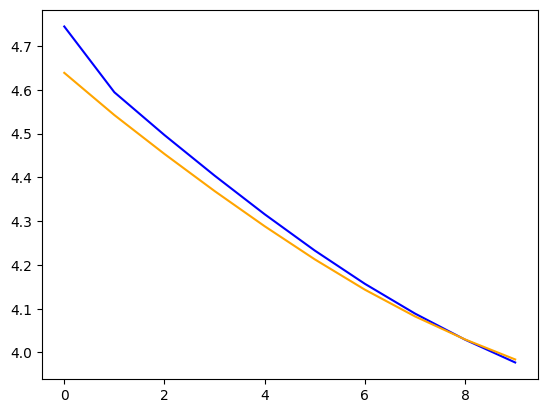

In [34]:
plt.plot(train_loss_list, color="blue")
plt.plot(validation_loss_list, color="orange")
plt.show()

In [35]:
def predict(model, input_sequence, max_length=MAX_LEN, SOS_token=SOS, EOS_token=EOS):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[SOS, 0, 104, 17, 38, 105]], dtype=torch.long, device=device),
    torch.tensor([[SOS, 0, 103]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 104, 17, 38]
Continuation: [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,

In [36]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': train_loss_list,
            'val_loss': validation_loss_list,
            }, "model_2.pt")

In [14]:
model = Transformer(
    num_tokens=123, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1,
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)

checkpoint = torch.load("model_1.pt")
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_list = checkpoint['train_loss']
validation_loss_list = checkpoint['val_loss']

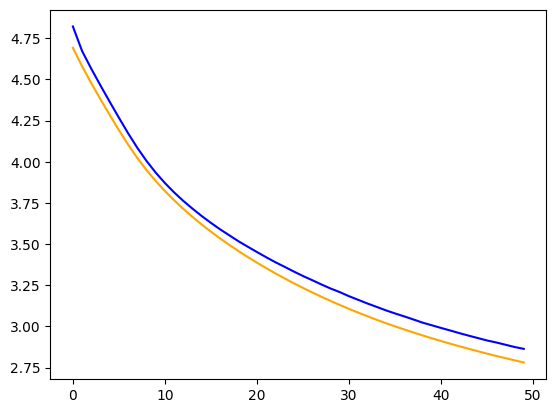

In [15]:
plt.plot(train_loss_list, color="blue")
plt.plot(validation_loss_list, color="orange")
plt.show()

In [11]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[SOS, 0, 104, 17, 38, 105]], dtype=torch.long, device=device),
    torch.tensor([[SOS, 0, 103]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 104, 17, 38]
Continuation: [38, 101, 38, 101, 38, 101, 38, 101, 38, 101, 38, 101, 38, 103, 38, 103, 38, 103, 38, 103, 38, 103, 38, 103, 38, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0, 103, 38, 0,

## With artificial data

In [24]:
import random

def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [25]:
print(type(val_dataloader))
print(len(val_dataloader))
print(type(val_dataloader[0]))
print(val_dataloader[0].shape)

<class 'list'>
187
<class 'numpy.ndarray'>
(16, 2, 10)


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=5, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [27]:
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 5)

Training and validating model
------------------------- Epoch 1 -------------------------
start training loop


100%|██████████| 562/562 [00:18<00:00, 30.92it/s]


start validation loop


100%|██████████| 187/187 [00:01<00:00, 113.51it/s]


Training loss: 1.0090
Validation loss: 0.4442

------------------------- Epoch 2 -------------------------
start training loop


100%|██████████| 562/562 [00:18<00:00, 30.65it/s]


start validation loop


100%|██████████| 187/187 [00:01<00:00, 112.36it/s]


Training loss: 0.4508
Validation loss: 0.3935

------------------------- Epoch 3 -------------------------
start training loop


100%|██████████| 562/562 [00:18<00:00, 30.19it/s]


start validation loop


100%|██████████| 187/187 [00:01<00:00, 112.84it/s]


Training loss: 0.4096
Validation loss: 0.3675

------------------------- Epoch 4 -------------------------
start training loop


100%|██████████| 562/562 [00:18<00:00, 30.59it/s]


start validation loop


100%|██████████| 187/187 [00:01<00:00, 112.24it/s]


Training loss: 0.3815
Validation loss: 0.3360

------------------------- Epoch 5 -------------------------
start training loop


100%|██████████| 562/562 [00:18<00:00, 30.07it/s]


start validation loop


100%|██████████| 187/187 [00:01<00:00, 109.85it/s]

Training loss: 0.3591
Validation loss: 0.3100



In [28]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 5
Input: [0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

